<a href="https://colab.research.google.com/github/ra397/COVID19-Author-Network/blob/main/Project2HealthData_AuthorNetworkAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv('metadata_April10_2020.csv')

In [3]:
# Function to parse authors string into a list of individual authors
def parse_authors(authors_str):
    if pd.isna(authors_str):
      return []
    authors_list = authors_str.split(";")
    authors_list = [author.strip() for author in authors_list if author.strip() != ""]
    return authors_list

# Test function
print(parse_authors('Myatt, Theodore A; Johnston, Sebastian L; Rudnick, Stephen; Milton, Donald K'))

['Myatt, Theodore A', 'Johnston, Sebastian L', 'Rudnick, Stephen', 'Milton, Donald K']


In [4]:
# Prepare data
# Apply the parsing function to the authors column
df['parsed_authors'] = df['authors'].apply(parse_authors)

# Create a list of lists of co-authors for each publication
co_author_lists = df['parsed_authors'].tolist()

In [5]:
# Create a new column 'num_authors' which is the number of authors on that paper
df['num_authors'] = df['parsed_authors'].apply(len)

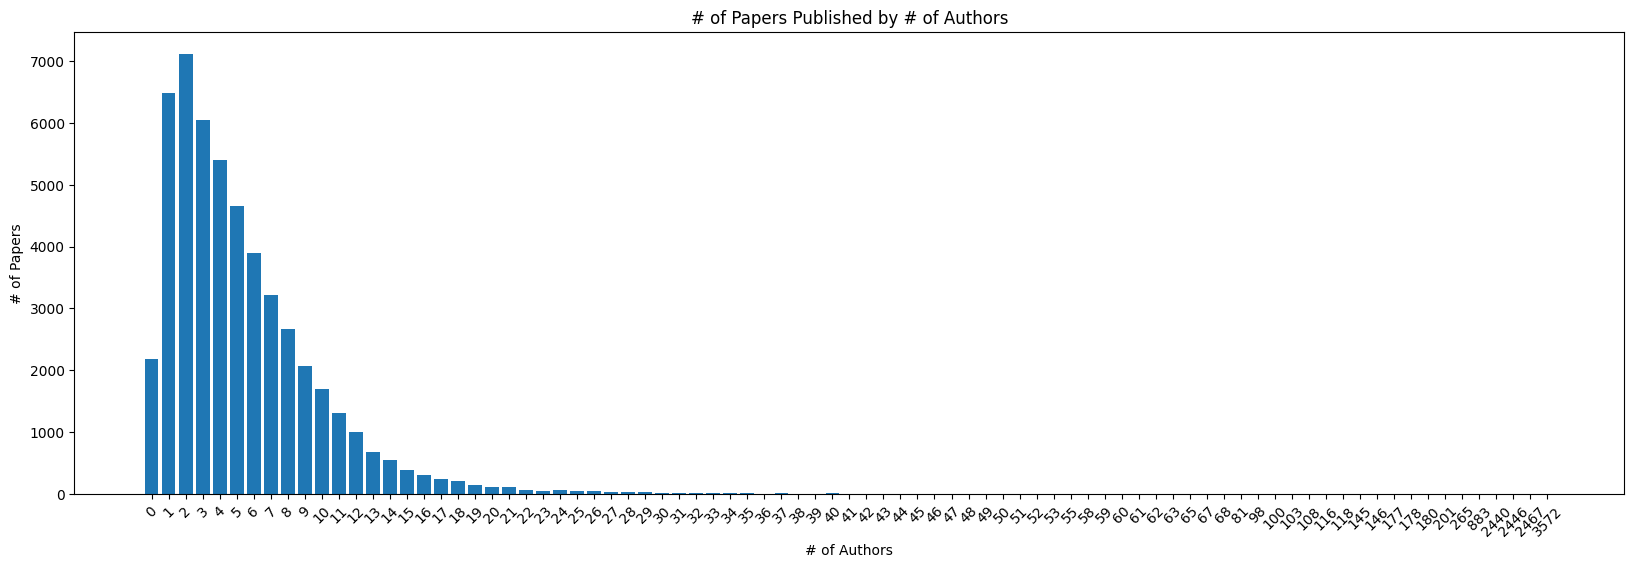

In [6]:
import matplotlib.pyplot as plt

num_authors_to_num_papers = {}
for row in df['num_authors']:
  if row not in num_authors_to_num_papers.keys():
    num_authors_to_num_papers[row] = 1
  else:
    num_papers = num_authors_to_num_papers[row]
    num_papers = num_papers + 1
    num_authors_to_num_papers[row] = num_papers

sorted_keys = sorted(num_authors_to_num_papers.keys())
sorted_values = [num_authors_to_num_papers[key] for key in sorted_keys]

# Now we'll plot again with the sorted keys and values
plt.figure(figsize=(20, 6))
plt.bar(range(len(sorted_keys)), sorted_values, tick_label=sorted_keys)

plt.title('# of Papers Published by # of Authors')
plt.xlabel('# of Authors')
plt.ylabel('# of Papers')

# Rotating the x-axis labels if needed (e.g., if they overlap)
plt.xticks(rotation=45)

# Show plot
plt.show()

The distribution of papers according to the number of authors listed on them.
- The histogram shows a right-skewed distribution. Few published papers had a high number of authors listed. Whereas the majority of published papers had a few number of authors listed (<15).
- The largest number of papers have a small number of authors, around 2-3.



In [7]:
import networkx as nx

def create_weighted_network(list_of_lists):
    # Initialize an empty graph
    G = nx.Graph()

    # Add all unique names as nodes
    unique_names = set(name for sublist in list_of_lists for name in sublist)
    for name in unique_names:
        G.add_node(name)

    # Create a dictionary to keep track of edge weights
    edges_count = {}

    # Iterate through each list to count occurrences of each pair
    for lst in list_of_lists:
        for i in range(len(lst)):
            for j in range(i+1, len(lst)):
                edge = tuple(sorted([lst[i], lst[j]]))  # Sort to ensure consistency
                if edge in edges_count:
                    edges_count[edge] += 1
                else:
                    edges_count[edge] = 1

    # Add edges with weights to the graph
    for edge, weight in edges_count.items():
        G.add_edge(edge[0], edge[1], weight=weight)

    return G

Network = create_weighted_network(co_author_lists)

##### Creating Co-Author Network Methodology
1. Iterate over the authors of each paper, extracting unique names. Each unique name is added to the ```graph``` as a node.
2. Keep track of edge weights using a ```dictionary```. The keys are edges, and their corresponding value is the edge weight.
3. For each research paper, consider every possible pair of authors. Order does not matter:```(author1, author2) = (author2, author1)```. Add that pair to the ```dictionary``` and update the weight if it already exists.
4. For each item in the ```dictionary```, add the edge to the ```graph``` along with it's corresponding weight.

In [8]:
print(f'Number of nodes: {Network.number_of_nodes()}')
print(f'Number of edges: {Network.number_of_edges()}')

Number of nodes: 180461
Number of edges: 10110290


In [ ]:
# The calculation for network density
n = Network.number_of_nodes()
max_edges = (n*(n-1)) / 2
density = Network.number_of_edges() / max_edges
print(f'Network Density: {density}')

Network Density: 0.0006209109172152762


- There are **180,461** different researchers who are listed as an author on a published COVID19 paper.
- The density of ***0.000621*** is quite low.
  - This is typical for large social networks. This reflects that while there may be a lot of collaboration, each author only collaborates with a relatively small subset of all the authors in the COVID19 research landscape.
  - This suggests that there are likely many authors who have only a few collaborations and a few highly connected authors (hubs) with a large number of collaborations.

In [46]:
# Rank by degree centrality
degree_centrality = nx.degree_centrality(Network)
sorted_centrality = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)
top_n_nodes = sorted_centrality[:119]

def print_table(data):
    print("Top 25 authors based on degree centrality:")
    # Define the headers
    headers = ['Author', 'Degree Centrality']

    # Find the maximum length of the string in the first column to align the columns
    max_length = max(len(author) for author, centrality in data)

    # Create a format string with dynamic padding for the first column
    row_format = "{:<" + str(max_length + 2) + "}{}"

    # Print the header
    print(row_format.format(*headers))

    # Print a separator
    print(row_format.format('-' * max_length, '-' * len(headers[1])))

    # Print the rows
    for author, centrality in data:
        print(row_format.format(author, centrality))

# Call the function to print the table
print_table(top_n_nodes)

Top 25 authors based on degree centrality:
Author             Degree Centrality
-----------------  -----------------
Wang, Jing         0.02677047545162363
Zhang, Li          0.026393660645018288
Chwae, Yong-Joon   0.02455945915992464
Mojoli, F.         0.021860800177324616
Torres, A.         0.021456278399645354
Rello, J.          0.02122908123683919
Dupont, H.         0.021212457054194837
Hajjar, L. A.      0.021212457054194837
Rhodes, A.         0.0211902914773357
Pearse, R. M.      0.0211902914773357
Armaganidis, A.    0.021184750083120915
Hou, P.            0.02117920868890613
Gul, F.            0.021173667294691344
Blot, S.           0.02116812590047656
Rehberg, S.        0.021145960323617423
Morgan, P.         0.021145960323617423
Cho, J.            0.021145960323617423
Kontar, L.         0.021145960323617423
Vincent, J. L.     0.021145960323617423
Cecconi, M.        0.021145960323617423
Schultz, M. J.     0.021145960323617423
Mauri, T.          0.021145960323617423
Decruyenaere

Higher degree centrality means:
- **Collaboration frequency**: the author collaborates with others more frequently.
- **Productivity**: the author published more frequently.
- **Position in the research community**: the author is more established in their field.

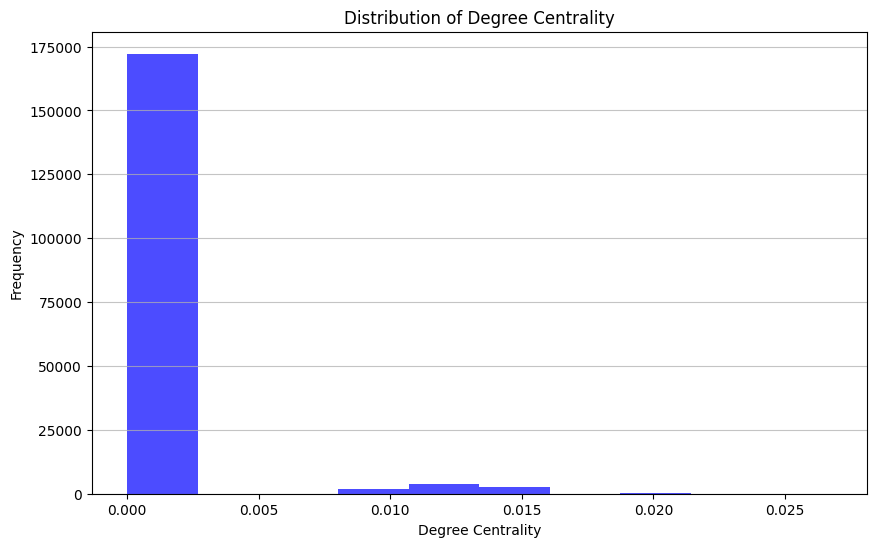

In [ ]:
degree_centrality_values = list(degree_centrality.values())

# Plot the distribution of degree centrality
plt.figure(figsize=(10, 6))
plt.hist(degree_centrality_values, bins=10, color='blue', alpha=0.7)
plt.title('Distribution of Degree Centrality')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

- High Frequency of Low Degree Centrality: the majority of authors in this network have collaborated with very few other authors.
- Very few authors have a high degree centrality.
- There are few authors who are highly connected within the network. Along with the low density this further points to a potential for hubs in this network.
- What are the reasons for low degree centrality? Are there lots of solo authors?

In [ ]:
num_solo_authored_papers = 0
num_papers = 0
for num_authors in df['num_authors']:
  num_papers += 1
  if num_authors <= 1:
    num_solo_authored_papers += 1
print(f'Percent of papers with at most 1 author: {(num_solo_authored_papers / num_papers) * 100} %')

Percent of papers with at most 1 author: 16.97991307412193 %


Approximately **17%** of the papers in the dataset were written by a single author.

In [ ]:
# Plot degree distribution of the network, this will help me choose the threshold for
# the minimum number of edges required for a node to be included in the visualization
import matplotlib.pyplot as plt

# Calculate the number of nodes that have at least each degree
degrees = [deg for node, deg in Network.degree()]
degrees.sort(reverse=True)
total_nodes = len(Network.nodes())
node_count_percent = [(sum(1 for deg in degrees if deg >= d) / total_nodes)
* 100 for d in range(max(degrees) + 1)]

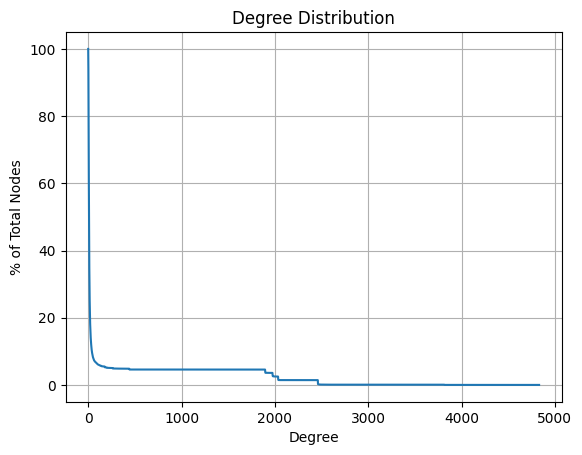

In [ ]:
# Plot degree distribution curve
plt.plot(range(max(degrees) + 1), node_count_percent, linestyle='-')
plt.xlabel('Degree')
plt.ylabel('% of Total Nodes')
plt.title('Degree Distribution')
plt.grid(True)
plt.show()

- We have a classic long-tail distribution. A high percentage of nodes have a very low degree, and as the degree increases, the percentage of nodes rapidly decreases.

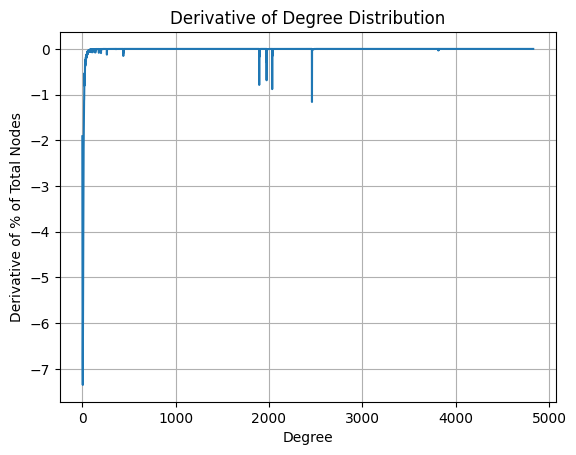

In [ ]:
# Calculate the derivative of the degree distribution curve
import numpy as np

derivative = np.diff(node_count_percent)

# Plot the derivative
plt.plot(range(1, len(derivative) + 1), derivative, linestyle='-')
plt.xlabel('Degree')
plt.ylabel('Derivative of % of Total Nodes')
plt.title('Derivative of Degree Distribution')
plt.grid(True)
plt.show()

 - The derivative graph is showing the difference in percentages between one degree and the next.
 - A long vertical line means there's a significant drop in the percentage of nodes when moving from degree n to n+1
 - A short or no vertical line means there's a small or no change in the percentage of nodes between these degrees


In [ ]:
degrees = dict(Network.degree())

# Calculate the frequency of each degree
degree_counts = {}
for degree in degrees.values():
    if degree in degree_counts:
        degree_counts[degree] += 1
    else:
        degree_counts[degree] = 1

# Sort the degrees and calculate the differences between consecutive degree frequencies
sorted_degrees = sorted(degree_counts.items())
differences = [(sorted_degrees[i+1][0], sorted_degrees[i+1][1] - sorted_degrees[i][1])
               for i in range(len(sorted_degrees)-1)]

# Find the degree with the largest decrease (most negative difference)
# Since the user asked for the biggest vertical line, we assume they are looking for the biggest drop
biggest_drop_degree = min(differences, key=lambda x: x[1])[0]

biggest_drop_degree

2461

- The ```biggest_drop_degree``` is the exact degree value for the biggest vertical line in the "Derivative of Degree Distribution".
- We will use ```biggest_drop_degree``` as the threshold for the minimum number of edges required for a node to be included in the visualization

In [ ]:
# Counts the number of nodes in a graph with a
def count_nodes_with_degree_at_least(graph, degree):
    count = 0
    for node in graph.nodes():
        if graph.degree(node) >= degree:
            count += 1
    return count

degree_to_count = count_nodes_with_degree_at_least(Network, biggest_drop_degree-1)
print(f'Number of nodes with degree {biggest_drop_degree-1}: {degree_to_count}')

threshold = 1855
degree_to_count = count_nodes_with_degree_at_least(Network, biggest_drop_degree)
print(f'Number of nodes with degree {biggest_drop_degree}: {degree_to_count}')

Number of nodes with degree 2460: 2577
Number of nodes with degree 2461: 482


In [43]:
degree_threshold = 3800

# Find nodes with a degree >= degree_threshold
nodes_with_min_degree = [node for node, degree in Network.degree() if degree >= degree_threshold]

# Count the number of such nodes
num_nodes_with_min_degree = len(nodes_with_min_degree)

num_nodes_with_min_degree

119

In [44]:
FilteredNetwork = Network.copy()
nodes_with_fewer_edges = [node for node, degree in FilteredNetwork.degree() if degree < 3800]
FilteredNetwork.remove_nodes_from(nodes_with_fewer_edges)
FilteredNetwork.number_of_nodes()

119

In [45]:
nx.write_gexf(FilteredNetwork, "Network.gexf")

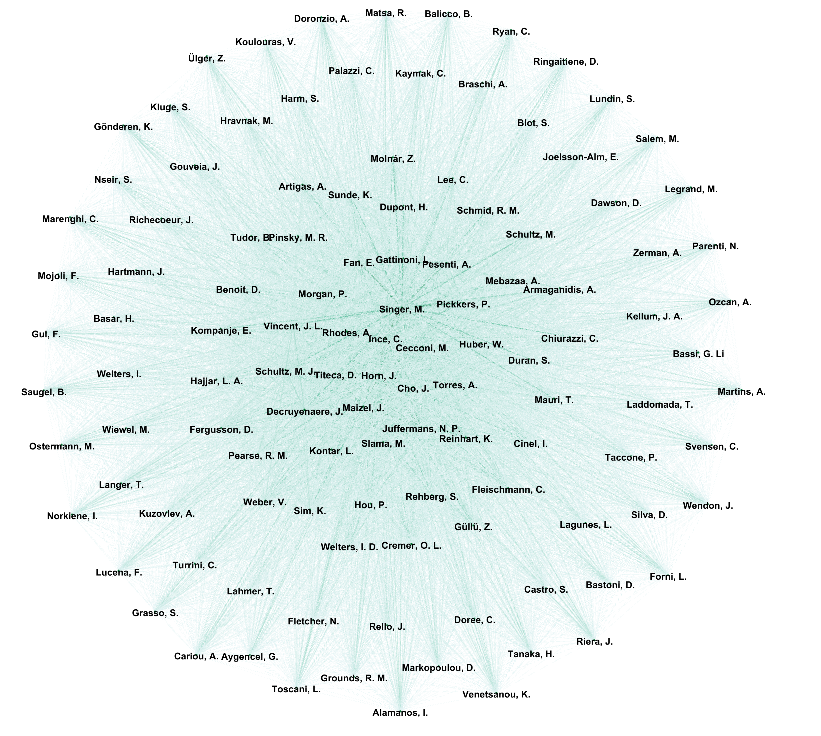

The most prominent researchers in the COVID19 landscape.